In [1]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
import keras
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Input, Add
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator

In [2]:
! nvidia-smi

Thu Jun  6 08:32:29 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
dataset_dir = 'drive/MyDrive/JBNU/dataset'

img_height = 224
img_width = 224

images = []
labels = []
class_names = []

for class_name in os.listdir(dataset_dir):
    class_dir = os.path.join(dataset_dir, class_name)
    if os.path.isdir(class_dir):
        class_names.append(class_name)
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            try:
                img = Image.open(img_path).resize((img_width, img_height)).convert('RGB')
                images.append(img)
                labels.append(class_name)
            except Exception as e:
                print(f"Erreur lors du traitement de l'image {img_path}: {e}")



In [4]:

images = np.array([np.array(img) for img in images])
labels = np.array(labels)

print(f"Nombre d'images chargées: {len(images)}")
print(f"Labels: {len(labels)}")

Nombre d'images chargées: 6603
Labels: 6603


In [5]:
print(len(labels))
label_binarizer = LabelBinarizer()
y = label_binarizer.fit_transform(labels)

x_train, x_test, y_train, y_test = train_test_split(images, y, test_size=0.2, random_state=123)

print(f"x_train shape: {x_train.shape}, y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape}, y_test shape: {y_test.shape}")
print(f"Class names: {label_binarizer.classes_}")


6603
x_train shape: (5282, 224, 224, 3), y_train shape: (5282, 11)
x_test shape: (1321, 224, 224, 3), y_test shape: (1321, 11)
Class names: ['dew' 'fogsmog' 'frost' 'glaze' 'hail' 'lightning' 'rain' 'rainbow'
 'rime' 'sandstorm' 'snow']


In [6]:

x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)
print('x_test shape:', x_test.shape)
print('y_test shape:', y_test.shape)

x_train shape: (5282, 224, 224, 3)
y_train shape: (5282, 11)
x_test shape: (1321, 224, 224, 3)
y_test shape: (1321, 11)


In [7]:
epochs = 25
batch_size = 64

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
train_generator = datagen.flow(x_train, y_train, batch_size=batch_size)

In [8]:
def residual_block(x, filters):
    shortcut = x
    x = Conv2D(filters, (3, 3), padding='same', activation='relu', kernel_initializer='he_uniform')(x)
    x = Conv2D(filters, (3, 3), padding='same', activation=None, kernel_initializer='he_uniform')(x)
    x = Add()([x, shortcut])
    x = keras.layers.Activation('relu')(x)
    return x

input_tensor = Input(shape=(224, 224, 3))
x = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(input_tensor)
x = residual_block(x, 32)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.2)(x)

x = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(x)
x = residual_block(x, 64)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.2)(x)

x = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(x)
x = residual_block(x, 128)
x = MaxPooling2D((2, 2))(x)
x = Dropout(0.2)(x)

x = Flatten()(x)
x = Dense(128, activation='relu', kernel_initializer='he_uniform')(x)
x = Dropout(0.2)(x)
output_tensor = Dense(11, activation='softmax')(x)

model = Model(inputs=input_tensor, outputs=output_tensor)

opt = keras.optimizers.Adam(lr=0.001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 224, 224, 32)         896       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 224, 224, 32)         9248      ['conv2d[0][0]']              
                                                                                                  
 conv2d_2 (Conv2D)           (None, 224, 224, 32)         9248      ['conv2d_1[0][0]']            
                                                                                              

In [9]:
images = []
history = model.fit(train_generator,
                    steps_per_epoch=len(x_train) // batch_size,
                    epochs=epochs,
                    validation_data=(x_test, y_test)
                   )

Epoch 1/25
82/82 [==============================] - 120s 1s/step - loss: 6.7915 - accuracy: 0.1646 - val_loss: 2.2409 - val_accuracy: 0.2256
Epoch 2/25
82/82 [==============================] - 82s 988ms/step - loss: 2.0112 - accuracy: 0.3191 - val_loss: 1.7640 - val_accuracy: 0.3982
Epoch 3/25
82/82 [==============================] - 83s 1s/step - loss: 1.6964 - accuracy: 0.4247 - val_loss: 1.4441 - val_accuracy: 0.5238
Epoch 4/25
82/82 [==============================] - 80s 973ms/step - loss: 1.4986 - accuracy: 0.4918 - val_loss: 1.3406 - val_accuracy: 0.5564
Epoch 5/25
82/82 [==============================] - 81s 985ms/step - loss: 1.4199 - accuracy: 0.5222 - val_loss: 1.2569 - val_accuracy: 0.6003
Epoch 6/25
82/82 [==============================] - 83s 1s/step - loss: 1.3278 - accuracy: 0.5431 - val_loss: 1.1983 - val_accuracy: 0.6132
Epoch 7/25
82/82 [==============================] - 88s 1s/step - loss: 1.2325 - accuracy: 0.5839 - val_loss: 1.1385 - val_accuracy: 0.6094
Epoch 8/25

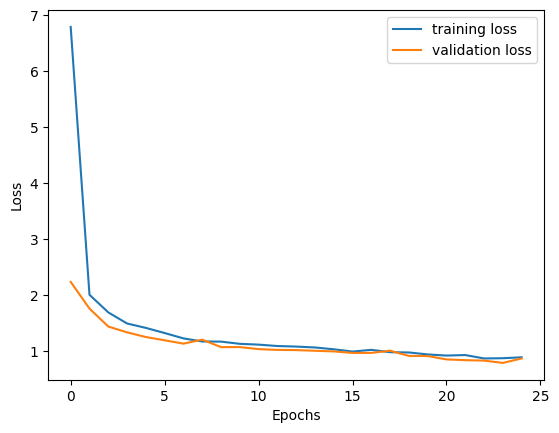

In [10]:
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [11]:
x_train=[]
y_train =[]
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)

42/42 - 2s - loss: 0.8746 - accuracy: 0.7086 - 2s/epoch - 57ms/step

Test accuracy: 0.7085541486740112
